# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [22]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

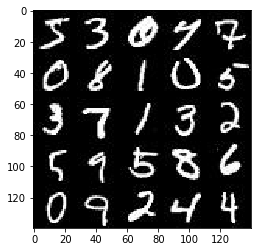

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

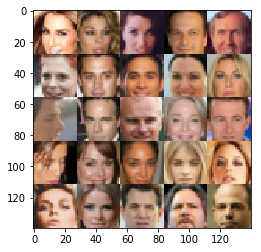

In [24]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/vikashkhanna/Applications/anaconda/envs/tflearn/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [26]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

### Helper Function for implementing Leaky ReLu

In [27]:
def lrelu(x, leak=0.2, name="lrelu"):
        with tf.variable_scope(name, reuse=False):
            f1 = 0.5 * (1 + leak)
            f2 = 0.5 * (1 - leak)
            return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2 #leak param for leaky Relu
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, in_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1 #leaky ReLu
    reuse = not in_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=in_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=in_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=in_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [31]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4489... Generator Loss: 5.8197
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 16.0503
Epoch 1/2... Discriminator Loss: 0.3591... Generator Loss: 6.2219
Epoch 1/2... Discriminator Loss: 0.3371... Generator Loss: 6.8307
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 12.9248
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 2.7982
Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 15.3130
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 8.4550
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 3.0719
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 1.3720


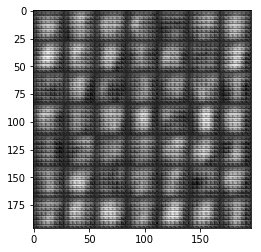

Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.5875
Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 3.4997
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 3.4425
Epoch 1/2... Discriminator Loss: 0.4947... Generator Loss: 2.0780
Epoch 1/2... Discriminator Loss: 0.3745... Generator Loss: 6.1275
Epoch 1/2... Discriminator Loss: 0.3798... Generator Loss: 4.0945
Epoch 1/2... Discriminator Loss: 0.3602... Generator Loss: 5.5993
Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 4.6513
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 5.6849
Epoch 1/2... Discriminator Loss: 0.5800... Generator Loss: 3.7211


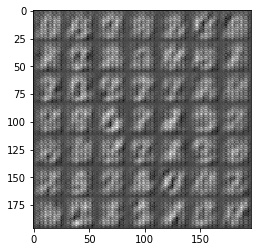

Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 1.9568
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.6059
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.3569
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.6809... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 2.0652
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 1.8473... Generator Loss: 0.4187
Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 1.6000


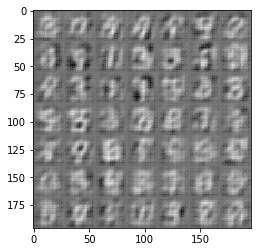

Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 1.7017
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.8875
Epoch 1/2... Discriminator Loss: 1.7218... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 1.1591
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.3196
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.6672


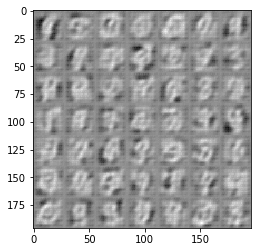

Epoch 1/2... Discriminator Loss: 1.7945... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 0.8557... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.2245... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.2579
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.6881


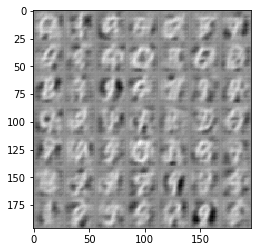

Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 1.5077
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 1.0903
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 1.4825
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 1.6838
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 2.3861
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 0.6580


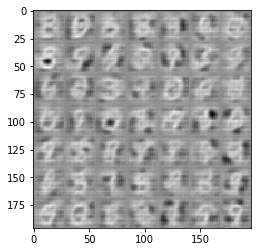

Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.4638
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.2053
Epoch 1/2... Discriminator Loss: 0.9216... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 1.5055
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.9640


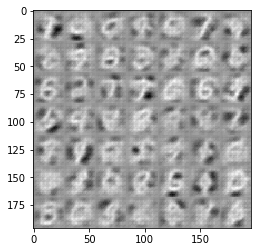

Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 1.1589
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.7729
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.8903
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.2973
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.1111
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.5441
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.5386


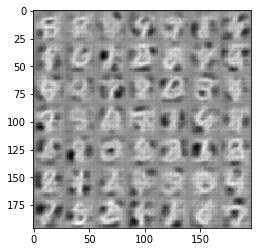

Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 2.1205
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.6883... Generator Loss: 0.3830
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.4960


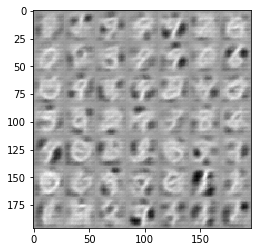

Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.4264
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 1.1538... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 3.6088
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.7008


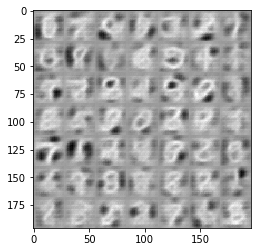

Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 1.3263
Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.0840
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.4520
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.6772
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.8734


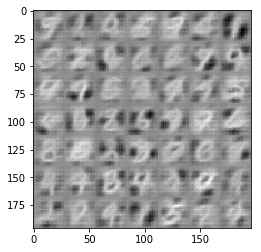

Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.1561
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 1.4055
Epoch 1/2... Discriminator Loss: 0.4988... Generator Loss: 3.1212
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.1413
Epoch 1/2... Discriminator Loss: 0.4803... Generator Loss: 2.6520
Epoch 1/2... Discriminator Loss: 0.4540... Generator Loss: 4.3299
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 2.8587


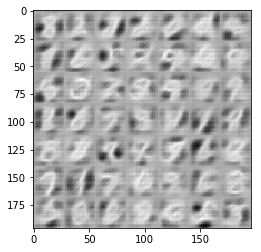

Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 0.7952... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.3403
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 1.2889
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.8739


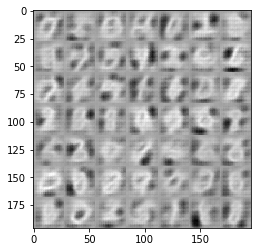

Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.8847... Generator Loss: 0.2874
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 2.2942


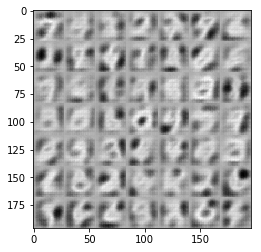

Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.3538
Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.6893
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.3614


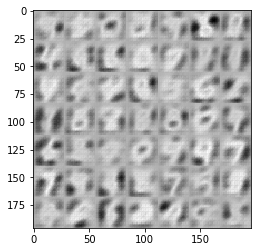

Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.1538
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 2.1812... Generator Loss: 0.2628
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 2.3586
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.7945


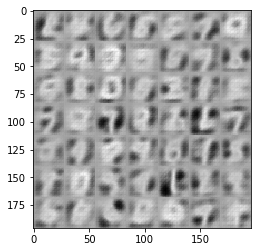

Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.7417
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.3243
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.6897
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.0218


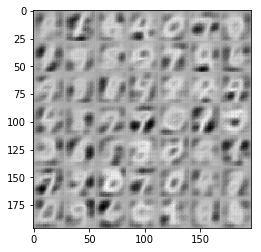

Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 1.3234
Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 2.3932
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.2495


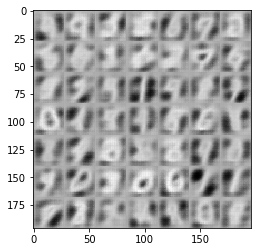

Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 1.0304
Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.1360
Epoch 1/2... Discriminator Loss: 2.5981... Generator Loss: 4.4294
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 1.3579
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.5029
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.3847


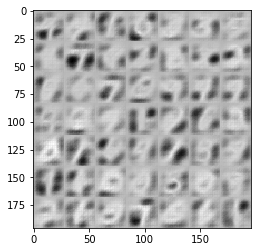

Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.4653
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 0.5745
Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.2042


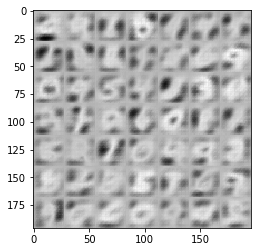

Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.4687
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.9045
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.2683


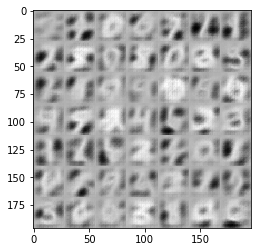

Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.6801
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.9228
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.4754
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.1553
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.4093
Epoch 2/2... Discriminator Loss: 0.6748... Generator Loss: 1.3884
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.2897


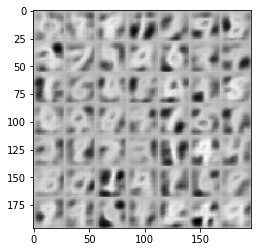

Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 2.0217
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 0.9808... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.4640
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.6745


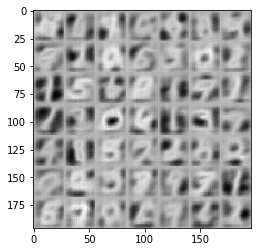

Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.9283
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.4591
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 1.3020
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 2.1001


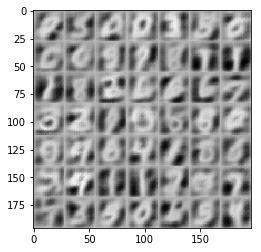

Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.0822
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.1537
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.5171... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.5318


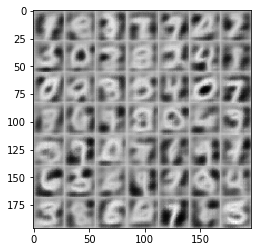

Epoch 2/2... Discriminator Loss: 2.2311... Generator Loss: 0.2362
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.5483
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.6541
Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 1.3745
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 0.9817


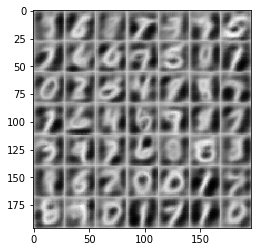

Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.5307
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.3835
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 1.9759
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.8691
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.2950


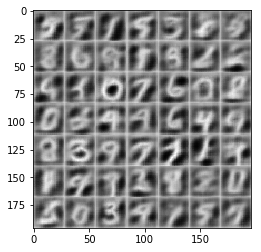

Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.5306
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.9659
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.9939
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.5112
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.5212


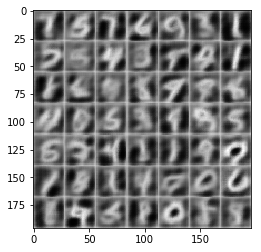

Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.6396
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 1.6044
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 1.9169
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.5501
Epoch 2/2... Discriminator Loss: 0.5746... Generator Loss: 2.1938
Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.8087


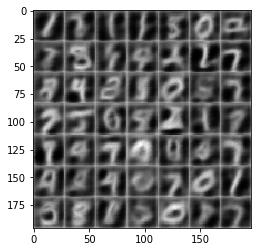

Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.5684
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 1.2161
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.5421
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.9587


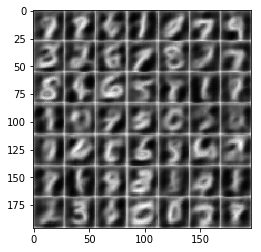

Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 2.2125
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.7815
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.9437
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.5547
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.2499


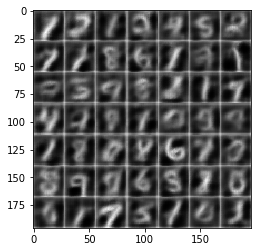

Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.3577
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 2.6882
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.9694
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 2.0852
Epoch 2/2... Discriminator Loss: 1.6118... Generator Loss: 0.4591
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.4028


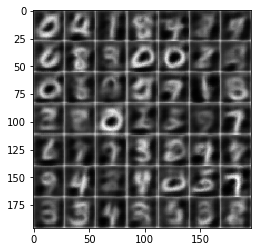

Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 2.5556
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 1.5606... Generator Loss: 0.4876
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.7736


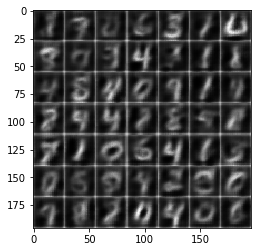

Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.8322
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.8032
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.5541
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 2.2685
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.5873
Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 1.8326
Epoch 2/2... Discriminator Loss: 1.6026... Generator Loss: 0.4308
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.6755
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.5323


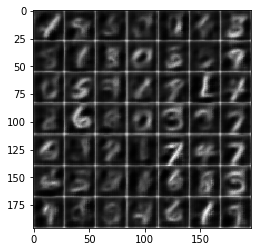

Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 0.7619... Generator Loss: 1.2834
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.4716... Generator Loss: 0.5745
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.6265
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 2.0834
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.9826
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 0.9996


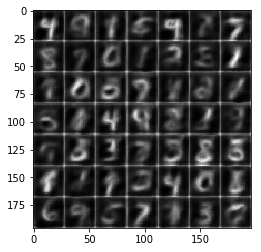

Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 0.5560... Generator Loss: 1.9880
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.7566
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 0.7847... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.9050


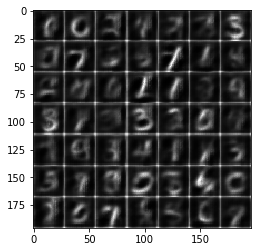

Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.6255
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 1.3351
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.4449
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.4661
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.3638
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.4081


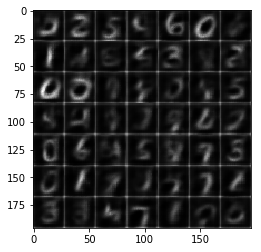

Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 2.2626
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.2382
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.8846


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.